In [1]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

In [40]:
import numpy as np
import pandas as pd
from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# setup a few things for TF on superpod to enable GPU use
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"  # 1
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit"
os.environ[
    "XLA_FLAGS"
] = "--xla_gpu_cuda_data_dir=/hpc/mp/repos/spack/opt/spack/linux-ubuntu22.04-zen2/gcc-11.2.0/cuda-11.8.0-vbvgppx4lxcpicxdd47ihqsx5egt4hey"


print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.14.0


In [41]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import FeatureSpace

from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [42]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [43]:
# setup the gpus, using mirrored to parallelize the training if we have multi-gpu
gpus = tf.config.list_logical_devices("GPU")
strategy = tf.distribute.MirroredStrategy(gpus)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Lab Assignment Five: Wide and Deep Network Architectures
In this lab, you will select a prediction task to perform on your dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

Author 1: Brandon Stevenson

## Dataset Selection

Select a dataset similarly to lab one. That is, the dataset must be table data and must have categorical features. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification, multi-class classification, or regression. You are NOT allowed to use the census (i.e., Adult) dataset that was given as an example in class. 

https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions/data

## Preparation (4 points total)
 - [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required.
 

In [44]:
df = pd.read_csv("lab_5/credit_card_transactions-ibm_v2.csv")

> I had some issues with the names, so I am just going to fix a few column names here to make things easier for myself.

In [45]:
df.rename(
    columns={
        "Use Chip": "Use_Chip",
        "Merchant Name": "Merchant_Name",
        "Merchant City": "Merchant_City",
        "Merchant State": "Merchant_State",
        "Errors?": "Errors",
        "Is Fraud?": "Is_Fraud",
    },
    inplace=True,
)

> Lets look at what we have

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use_Chip        object 
 8   Merchant_Name   int64  
 9   Merchant_City   object 
 10  Merchant_State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors          object 
 14  Is_Fraud        object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [47]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [48]:
df.nunique()

User                2000
Card                   9
Year                  30
Month                 12
Day                   31
Time                1440
Amount             98953
Use_Chip               3
Merchant_Name     100343
Merchant_City      13429
Merchant_State       223
Zip                27321
MCC                  109
Errors                23
Is_Fraud               2
dtype: int64

In [49]:
df.isna().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use_Chip                 0
Merchant_Name            0
Merchant_City            0
Merchant_State     2720821
Zip                2878135
MCC                      0
Errors            23998469
Is_Fraud                 0
dtype: int64

> Looking at this data we can see that we should manipulate a few items. First, we should modify the `Time` feature to be a more ML friendly, one idea would be to split this into two catagories, i.e. the hour and minutes; We could also just combine these into a single value, the minutes since 00:00. I think it will be best to combine them into a single category for learning. The `Amount` column can be converted to a float, with the possibility of adding a new currency feature if there are non-USD amounts.  `Use Chip` needs to be encoded. `Merchant Name` has been encoded by the data generator but we will need to do the same to `Merchant City` and `Merchant State`. `Errors?` needs to be looked at more to decide what to do and `Is Fraud?` is our target so we will need to drop that.
>
> We also need to think about what to do with the na values. We could drop them, but that would be a lot of data. For `Errors?` we can realize that na is not a failure of the data, but just a negative so we can convert that to 'no'. For `state` and `zip` we could consider throwing away about 10% of the data, but I think it would be better to just encode the na values as a new category assuming that is a feature of the data collection and not a failure.
>
> Beside that we need to be careful to tell the model that many of these are discrete values. In fact, amount is this only non-discrete value.

In [50]:
df["Card"].value_counts(dropna=False)

Card
0    8696411
1    6493597
2    4305594
3    2790785
4    1309120
5     563097
6     176729
7      46383
8       5184
Name: count, dtype: int64

In [51]:
df["Merchant_State"].value_counts(dropna=False)

Merchant_State
NaN                                 2720821
CA                                  2591830
TX                                  1793298
FL                                  1458699
NY                                  1446864
                                     ...   
Democratic Republic of the Congo          2
Tonga                                     2
Kiribati                                  1
Paraguay                                  1
Botswana                                  1
Name: count, Length: 224, dtype: int64

In [52]:
df["Errors"].value_counts(dropna=False)

Errors
NaN                                                    23998469
Insufficient Balance                                     242783
Bad PIN                                                   58918
Technical Glitch                                          48157
Bad Card Number                                           13321
Bad CVV                                                   10740
Bad Expiration                                            10716
Bad Zipcode                                                2079
Bad PIN,Insufficient Balance                                581
Insufficient Balance,Technical Glitch                       457
Bad PIN,Technical Glitch                                    128
Bad Card Number,Insufficient Balance                        122
Bad CVV,Insufficient Balance                                 89
Bad Expiration,Insufficient Balance                          78
Bad Card Number,Bad CVV                                      60
Bad Card Number,Bad Expiration   

> It looks like `Errors?` might be a cross cat that has been hashed based on several possible errors. We wont change anything here right now but maybe we could seperate these but im not going to. We also need to be careful of the nan values here, which do not actually indicate an error in the data. Besides that we can do the normal string encoding on this data. 

In [53]:
# convert Time to minutes since 00:00
df["Time"] = df["Time"].apply(
    lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1])
)

# convert Amount to float, also ensures that we only have USD values
df["Amount"] = df["Amount"].str.replace("$", "").astype(float)

# convert any NaN values to something else
df["Merchant_State"].fillna("N/A", inplace=True)
df["Zip"].fillna(0, inplace=True)
df["Errors"].fillna("No", inplace=True)

# I just dont like that the zip is a float...
df["Zip"] = df["Zip"].astype(int)

# save our target, and drop the Is Fraud? column
df["Is_Fraud"] = df["Is_Fraud"].map({"No": False, "Yes": True})
# df = df.drop(columns=["Is Fraud?"])

In [54]:
# lets store some column names for later

cat_cols = [
    "Use_Chip",
    "Merchant_State",
    "Merchant_City",
    "Merchant_Name",
    "Zip",
    "Errors",
]

discrete_cols = ["User", "Card", "Year", "Month", "Day", "Time", "Zip", "MCC"]

num_cols = ["Amount"]

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            int64  
 6   Amount          float64
 7   Use_Chip        object 
 8   Merchant_Name   int64  
 9   Merchant_City   object 
 10  Merchant_State  object 
 11  Zip             int64  
 12  MCC             int64  
 13  Errors          object 
 14  Is_Fraud        bool   
dtypes: bool(1), float64(1), int64(9), object(4)
memory usage: 2.6+ GB


In [56]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud
0,0,0,2002,9,1,381,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750,5300,No,False
1,0,0,2002,9,1,402,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,No,False
2,0,0,2002,9,2,382,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,No,False
3,0,0,2002,9,2,1065,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754,5651,No,False
4,0,0,2002,9,3,383,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750,5912,No,False


In [57]:
df["Errors"].value_counts(dropna=False)

Errors
No                                                     23998469
Insufficient Balance                                     242783
Bad PIN                                                   58918
Technical Glitch                                          48157
Bad Card Number                                           13321
Bad CVV                                                   10740
Bad Expiration                                            10716
Bad Zipcode                                                2079
Bad PIN,Insufficient Balance                                581
Insufficient Balance,Technical Glitch                       457
Bad PIN,Technical Glitch                                    128
Bad Card Number,Insufficient Balance                        122
Bad CVV,Insufficient Balance                                 89
Bad Expiration,Insufficient Balance                          78
Bad Card Number,Bad CVV                                      60
Bad Card Number,Bad Expiration   

In [58]:
df["Is_Fraud"].value_counts(dropna=False)

Is_Fraud
False    24357143
True        29757
Name: count, dtype: int64

> Need to aug the training but not test or val

> Now, we can convert this datafram into tfdata, because why not im here to learn. We will also setup the data with featurespec.

In [59]:
# lets balance our data since we have soo much we can just drop some to get 60,000 points
# We could do this a bit better by ensuring that we have a good distribution of all catagories for each of our catagories columns, balanced on is_Fraud
# but this is good enough for now
non_fraud_df = df[df["Is_Fraud"] == 0]
fraud_df = df[df["Is_Fraud"] == 1]

non_fraud_df = non_fraud_df.sample(len(fraud_df), replace=False)
df_balanced = pd.concat([fraud_df, non_fraud_df], axis=0)

In [60]:
# create a tensorflow dataset, for ease of use later
batch_size = 64
prefetch_size = 32

def create_dataset_from_dataframe(df_input, target):
    df = df_input.copy()
    labels = df[target]
    df.drop(columns=[target], inplace=True)

    df = {key: value.values[:, np.newaxis] for key, value in df.items()}

    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    return ds


tf_data = create_dataset_from_dataframe(df_balanced, "Is_Fraud")

 
 - [1 points] Identify groups of features in your data that should be combined into cross-product features. Provide a compelling justification for why these features should be crossed (or why some features should not be crossed). 
 


> A few obvious cross features:
>
>user,card,use chip
> - This will allow us to see if a user is using a card in a way that is not normal for them
>
>
>user, Merchant Name, Merchant State, zip
> - might help flag odd merchants or bad actors
>
>user, zip
> -  could once again 
> 
>year month day time

 - [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
 


> F1 score would be good as we want to balanced false positives (flagging good transactions as fraud), and false negatives (letting fraud happen). AUC maybe???

 - [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. Use the method to split your data that you argue for. 

In [61]:
# Now we setup the tfdataset
tf_data = tf_data.shuffle(buffer_size=10000)

train_size = int(0.8 * len(df_balanced))
val_size = int(0.1 * len(df_balanced))
test_size = int(0.1 * len(df_balanced))

ds_train = tf_data.take(train_size).batch(
    batch_size, num_parallel_calls=tf.data.AUTOTUNE
)
ds_val = (
    tf_data.skip(train_size)
    .take(val_size)
    .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
)
ds_test = (
    tf_data.skip(train_size + val_size)
    .take(test_size)
    .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
)

In [62]:
feature_space = FeatureSpace(
    features={
        "User": FeatureSpace.integer_categorical(name="user", output_mode="int"),
        "Card": FeatureSpace.integer_categorical(name="card", output_mode="int"),
        "Year": FeatureSpace.integer_categorical(name="year", output_mode="int"),
        "Month": FeatureSpace.integer_categorical(name="month", output_mode="int"),
        "Day": FeatureSpace.integer_categorical(name="day", output_mode="int"),
        "Time": FeatureSpace.integer_categorical(name="time", output_mode="int"),
        "Amount": FeatureSpace.float_normalized(name="amount"),
        "Use_Chip": FeatureSpace.string_categorical(name="use_chip", output_mode="int"),
        "Merchant_Name": FeatureSpace.integer_categorical(
            name="merchant_name", output_mode="int"
        ),
        "Merchant_City": FeatureSpace.string_categorical(
            name="merchant_city", output_mode="int"
        ),
        "Merchant_State": FeatureSpace.string_categorical(
            name="merchant_state", output_mode="int"
        ),
        "Zip": FeatureSpace.integer_categorical(name="zip", output_mode="int"),
        "MCC": FeatureSpace.integer_categorical(name="mcc", output_mode="int"),
        "Errors": FeatureSpace.string_categorical(name="errors", output_mode="int"),
    },
    crosses=[
        FeatureSpace.cross(
            feature_names=("Month", "Day", "Time"),  # not sure....
            crossing_dim=12 * 31 * 1440,
            output_mode="int",
        ),
        FeatureSpace.cross(
            feature_names=("Card", "Use_Chip", "MCC"),
            crossing_dim=9 * 3 * 109,
            output_mode="int",
        ),
    ],
    output_mode="dict",
)

In [63]:
# now that we have specified the preprocessing, let's run it on the data
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

preprocessed_train = ds_train.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

preprocessed_test = ds_test.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

## Modeling (5 points total)



 - [2 points] Create at least three combined wide and deep networks to classify your data using Keras (this total of "three" includes the model you will train in the next step of the rubric). Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations.
Note: you can use the "history" return parameter that is part of Keras "fit" function to easily access this data.


### Model 1: in class model

In [64]:
def setup_embedding_from_encoding(encoded_features, col_name):
    # what the maximum integer value for this variable?

    # get the size of the feature
    x = encoded_features[col_name]
    N = x.shape[1]

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(
        input_dim=N,
        output_dim=int(np.sqrt(N)),
        input_length=1,
        name=col_name + "_embed",
    )(x)

    x = Flatten()(x)  # get rid of that pesky extra dimension (for time of embedding)

    return x

In [65]:
dict_inputs = (
    feature_space.get_inputs()
)  # need to use unprocessed features here, to gain access to each output
encoded_features = (
    feature_space.get_encoded_features()
)  # these features have been encoded

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    x = setup_embedding_from_encoding(encoded_features, col)

    # save these outputs in list to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name="wide_concat")(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for col in discrete_cols:
    x = encoded_features[col]
    x = tf.cast(x, float)  # cast an integer as a float here
    all_deep_branch_outputs.append(x)

for col in num_cols:
    x = feature_space.preprocessors[col].output
    x = tf.cast(x, float)  # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in cat_cols:
    # get the output tensor from ebedding layer
    x = setup_embedding_from_encoding(encoded_features, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

In [66]:

def make_model_1(layers=(50,25,10), return_inference_model=False):
    # merge the deep branches together
    deep_branch = Concatenate(name="embed_concat")(all_deep_branch_outputs)
    deep_branch = Dense(units=layers[0], activation="relu", name="deep1")(deep_branch)
    deep_branch = Dense(units=layers[1], activation="relu", name="deep2")(deep_branch)
    deep_branch = Dense(units=layers[2], activation="relu", name="deep3")(deep_branch)

    # merge the deep and wide branch
    final_branch = Concatenate(name="concat_deep_wide")([deep_branch, wide_branch])
    final_branch = Dense(units=1, activation="sigmoid", name="combined")(final_branch)

    # encoded features input, fast
    model = keras.Model(inputs=encoded_features, outputs=final_branch)
    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "AUC"]
    )

    if return_inference_model:
        inference_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
        inference_model.compile(loss="binary_crossentropy", metrics=["accuracy", "AUC"])
        return model, inference_model
    return model

training_model, inference_model = make_model_1(return_inference_model=True)
training_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_80 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_77 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_73 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_71 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                            

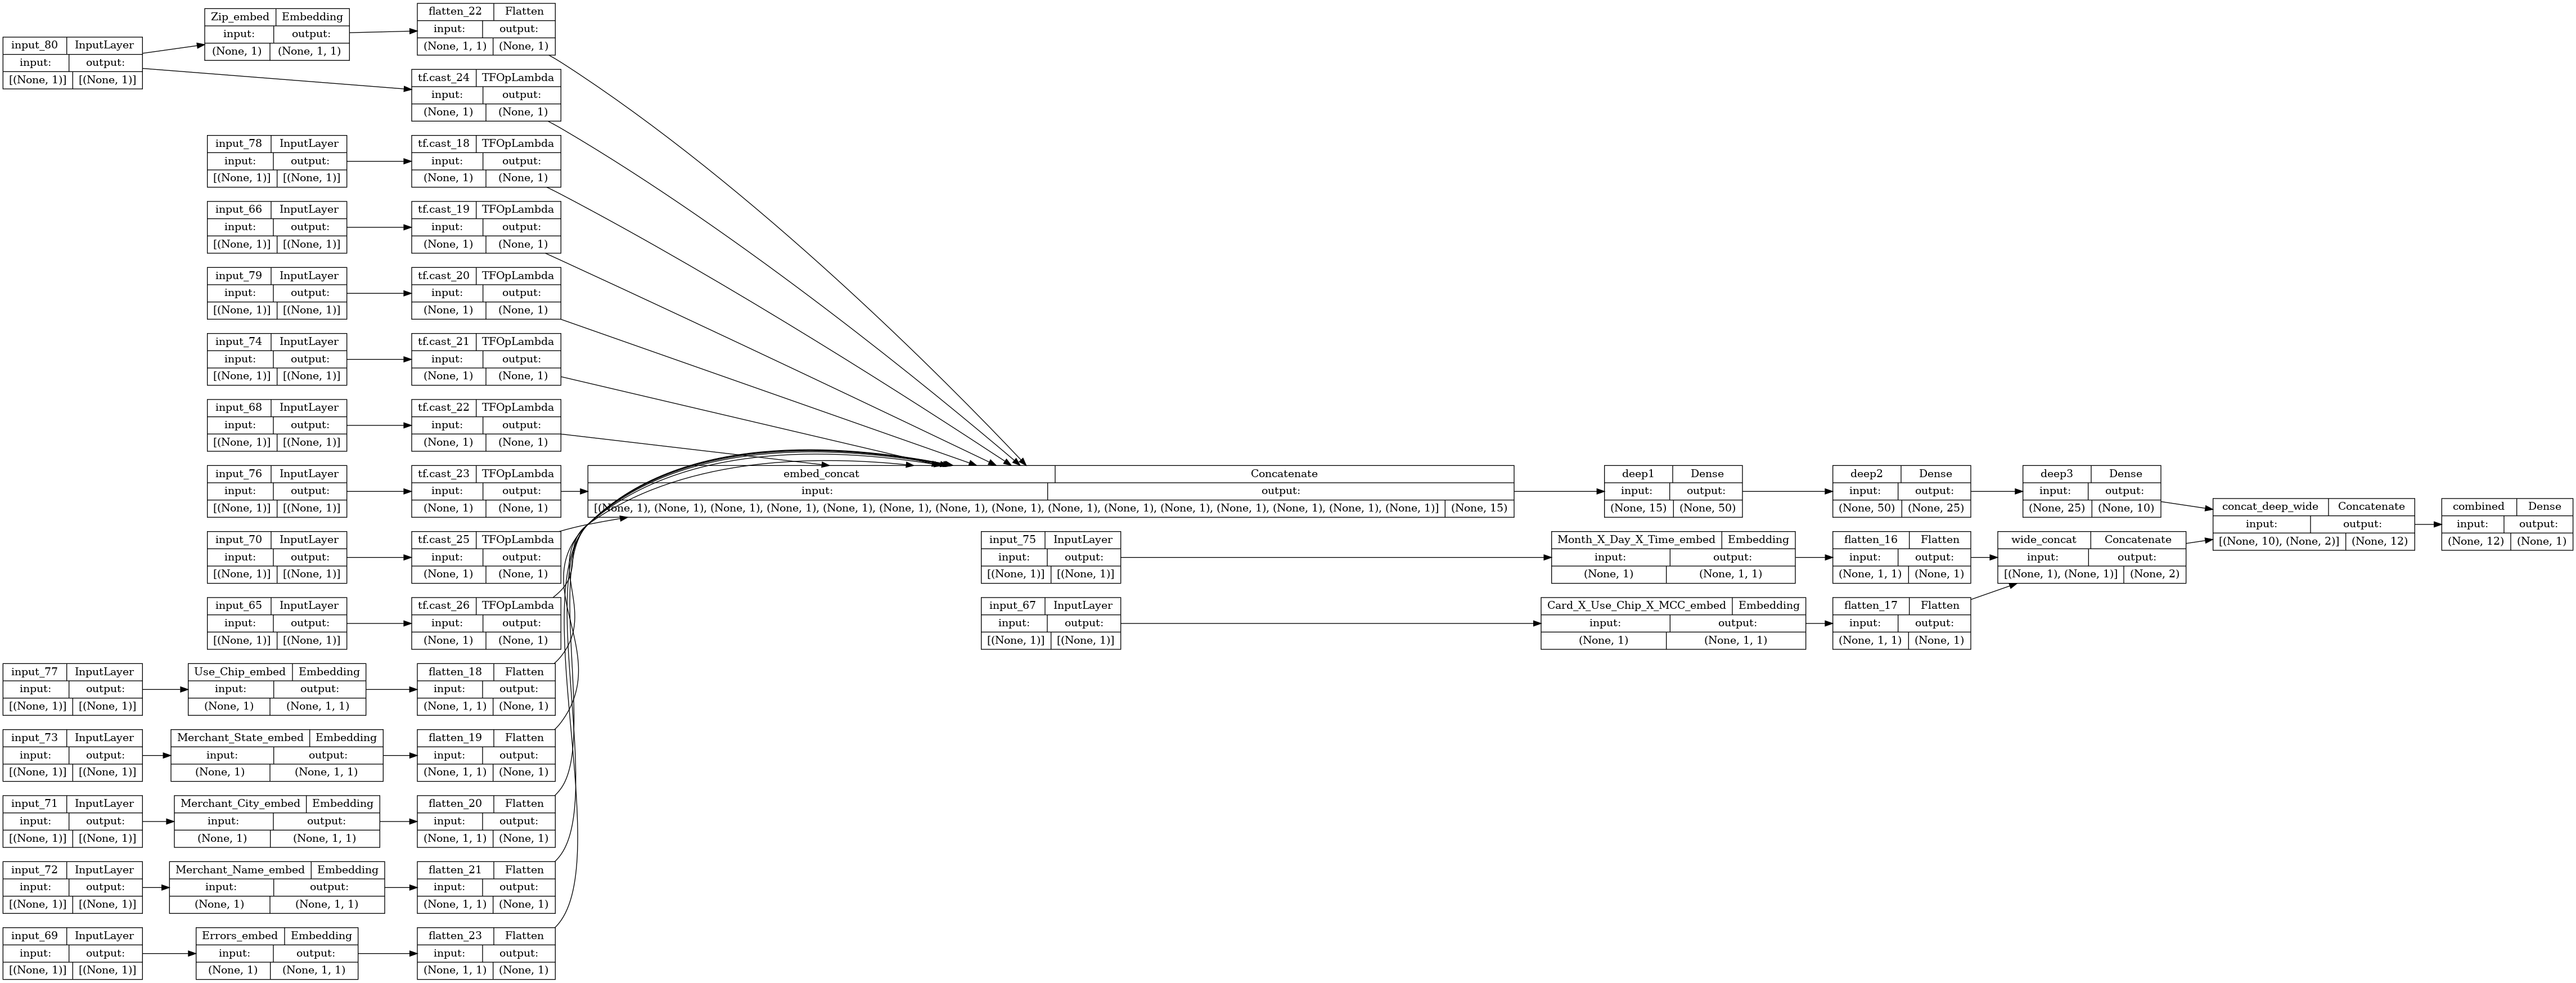

In [67]:
plot_model(
    training_model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [68]:
history = training_model.fit(
    preprocessed_train, epochs=10, validation_data=preprocessed_test, verbose=2
)

Epoch 1/10
744/744 - 16s - loss: 1.2610 - accuracy: 0.9020 - auc: 0.9472 - val_loss: 0.1992 - val_accuracy: 0.9437 - val_auc: 0.8487 - 16s/epoch - 22ms/step
Epoch 2/10
744/744 - 6s - loss: 0.3466 - accuracy: 0.9238 - auc: 0.9682 - val_loss: 0.1738 - val_accuracy: 0.9471 - val_auc: 0.8690 - 6s/epoch - 8ms/step
Epoch 3/10
744/744 - 6s - loss: 0.2502 - accuracy: 0.9255 - auc: 0.9723 - val_loss: 0.1556 - val_accuracy: 0.9494 - val_auc: 0.8698 - 6s/epoch - 8ms/step
Epoch 4/10
744/744 - 7s - loss: 0.2170 - accuracy: 0.9292 - auc: 0.9751 - val_loss: 0.1567 - val_accuracy: 0.9516 - val_auc: 0.8720 - 7s/epoch - 9ms/step
Epoch 5/10
744/744 - 7s - loss: 0.2231 - accuracy: 0.9223 - auc: 0.9750 - val_loss: 0.1718 - val_accuracy: 0.9462 - val_auc: 0.8690 - 7s/epoch - 9ms/step
Epoch 6/10
744/744 - 10s - loss: 0.2177 - accuracy: 0.9088 - auc: 0.9737 - val_loss: 0.1722 - val_accuracy: 0.9499 - val_auc: 0.8317 - 10s/epoch - 13ms/step
Epoch 7/10
744/744 - 12s - loss: 0.2082 - accuracy: 0.9268 - auc: 0.97

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


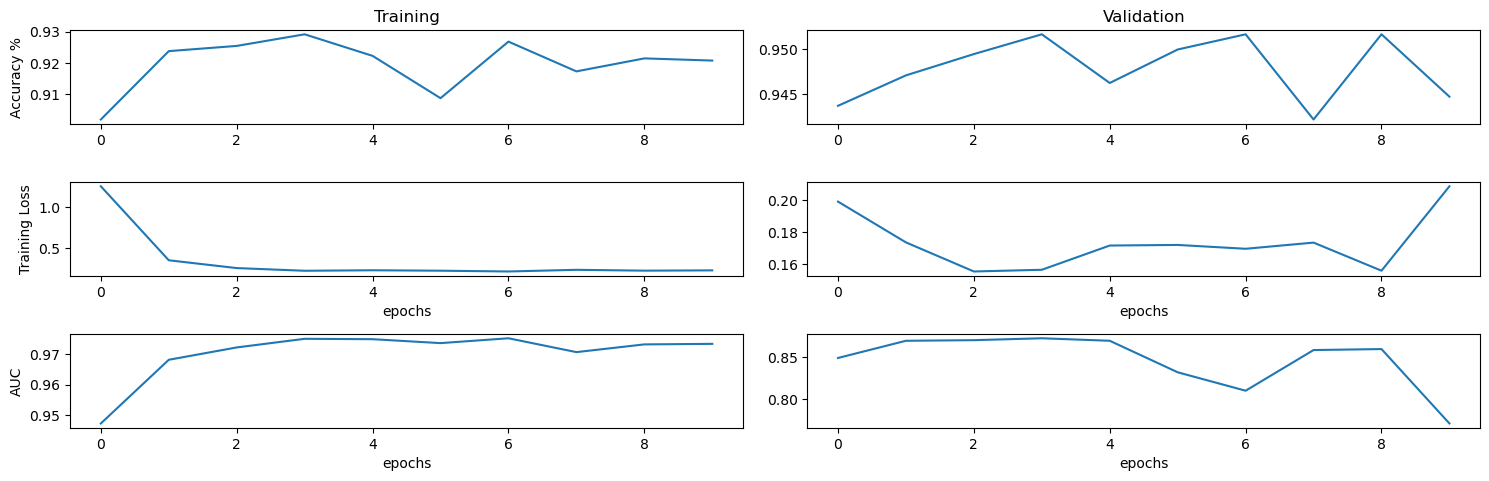

In [69]:
def plot_hist():
    print(history.history.keys())

    plt.figure(figsize=(15,6))
    plt.subplot(4,2,1)
    plt.plot(history.history['accuracy'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(4,2,2)
    plt.plot(history.history['val_accuracy'])
    plt.title('Validation')

    plt.subplot(4,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(4,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')

    plt.subplot(4,2,5)
    plt.plot(history.history['auc'])
    plt.ylabel('AUC')
    plt.xlabel('epochs')

    plt.subplot(4,2,6)
    plt.plot(history.history['val_auc'])
    plt.xlabel('epochs')

    # plt.subplot(4,2,7)
    # plt.plot(history.history['f1_score'])
    # plt.ylabel('AUC')
    # plt.xlabel('epochs')

    # plt.subplot(4,2,8)
    # plt.plot(history.history['val_f1_score'])
    # plt.xlabel('epochs')

    plt.tight_layout()

plot_hist()

In [70]:
inference_model.evaluate(ds_test)

93/93 [==============================] - 1s 3ms/step - loss: 0.1939 - accuracy: 0.9501 - auc: 0.7807


[0.19391387701034546, 0.9500924348831177, 0.7807071805000305]

### Model 2: Shallow with dropout

In [71]:
# merge the deep branches together
def make_model_2(layers=(50,25)):
    deep_branch = Concatenate(name="embed_concat")(all_deep_branch_outputs)
    deep_branch = Dense(units=layers[0], activation="relu", name="deep1")(deep_branch)

    # lets add a drop out, in case we this we are overfitting
    deep_branch = Dropout(0.2)(deep_branch)
    deep_branch = Dense(units=layers[1], activation="relu", name="deep2")(deep_branch)

    # Lets also make it a bit shallower
    # deep_branch = Dense(units=10, activation="relu", name="deep3")(deep_branch)

    # merge the deep and wide branch
    final_branch = Concatenate(name="concat_deep_wide")([deep_branch, wide_branch])
    final_branch = Dense(units=1, activation="sigmoid", name="combined")(final_branch)

    # encoded features input, fast
    model_2 = keras.Model(inputs=encoded_features, outputs=final_branch)
    model_2.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "AUC"]
    )

model_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_48 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_45 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_39 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                            

Epoch 1/10
744/744 - 12s - loss: 0.2172 - accuracy: 0.9191 - auc: 0.9722 - val_loss: 0.1588 - val_accuracy: 0.9511 - val_auc: 0.9037 - 12s/epoch - 16ms/step
Epoch 2/10
744/744 - 15s - loss: 0.2197 - accuracy: 0.9180 - auc: 0.9737 - val_loss: 0.1624 - val_accuracy: 0.9456 - val_auc: 0.8586 - 15s/epoch - 20ms/step
Epoch 3/10
744/744 - 17s - loss: 0.2161 - accuracy: 0.9167 - auc: 0.9738 - val_loss: 0.1479 - val_accuracy: 0.9541 - val_auc: 0.9042 - 17s/epoch - 22ms/step
Epoch 4/10
744/744 - 12s - loss: 0.2162 - accuracy: 0.9108 - auc: 0.9721 - val_loss: 0.1446 - val_accuracy: 0.9486 - val_auc: 0.8900 - 12s/epoch - 17ms/step
Epoch 5/10
744/744 - 13s - loss: 0.2118 - accuracy: 0.9137 - auc: 0.9732 - val_loss: 0.1627 - val_accuracy: 0.9311 - val_auc: 0.9008 - 13s/epoch - 18ms/step
Epoch 6/10
744/744 - 15s - loss: 0.2227 - accuracy: 0.9034 - auc: 0.9700 - val_loss: 0.1911 - val_accuracy: 0.8397 - val_auc: 0.8940 - 15s/epoch - 20ms/step
Epoch 7/10
744/744 - 22s - loss: 0.2270 - accuracy: 0.9057

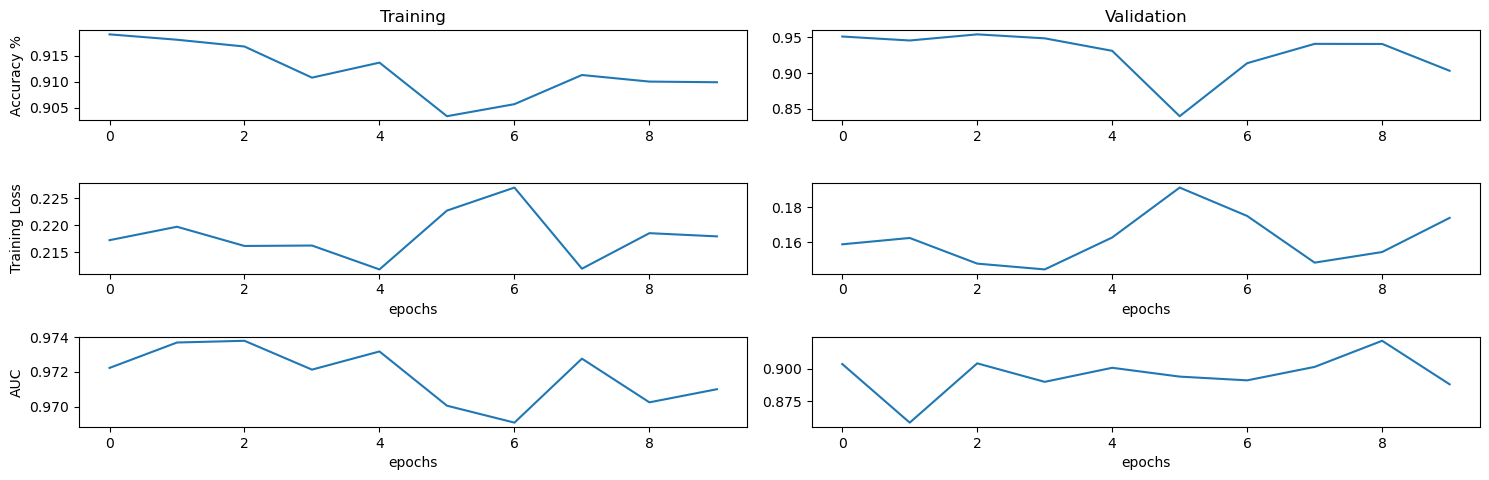

In [72]:
history = model_2.fit(
    preprocessed_train, epochs=10, validation_data=preprocessed_test, verbose=2
)

plot_hist()

### Model 3: The big boy

Just make a really deep network, adding dropout too to help with the overfitting

In [73]:
# merge the deep branches together
def make_model_3(layers=(256, 128, 64, 32, 16)):
    deep_branch = Concatenate(name="embed_concat")(all_deep_branch_outputs)
    deep_branch = Dense(units=layers[0], activation="relu", name="deep1")(deep_branch)
    deep_branch = Dropout(0.2)(deep_branch)

    deep_branch = Dense(units=layers[1], activation="relu", name="deep2")(deep_branch)
    deep_branch = Dropout(0.2)(deep_branch)

    deep_branch = Dense(units=layers[2], activation="relu", name="deep3")(deep_branch)

    deep_branch = Dense(units=layers[3], activation="relu", name="deep4")(deep_branch)

    deep_branch = Dense(units=layers[4], activation="relu", name="deep5")(deep_branch)

    # merge the deep and wide branch
    final_branch = Concatenate(name="concat_deep_wide")([deep_branch, wide_branch])
    final_branch = Dense(units=1, activation="sigmoid", name="combined")(final_branch)

    # encoded features input, fast
    model_3 = keras.Model(inputs=encoded_features, outputs=final_branch)
    model_3.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "AUC"]
    )

    return model_3

model_3 = make_model_3()
model_3.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_96 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_93 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_89 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_87 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                            

Epoch 1/10
744/744 - 17s - loss: 0.4870 - accuracy: 0.8975 - auc: 0.9514 - val_loss: 0.1830 - val_accuracy: 0.9471 - val_auc: 0.8425 - 17s/epoch - 23ms/step
Epoch 2/10
744/744 - 7s - loss: 0.2353 - accuracy: 0.9161 - auc: 0.9699 - val_loss: 0.1500 - val_accuracy: 0.9504 - val_auc: 0.8883 - 7s/epoch - 9ms/step
Epoch 3/10
744/744 - 8s - loss: 0.2161 - accuracy: 0.9135 - auc: 0.9720 - val_loss: 0.1476 - val_accuracy: 0.9511 - val_auc: 0.8731 - 8s/epoch - 11ms/step
Epoch 4/10
744/744 - 10s - loss: 0.2162 - accuracy: 0.9163 - auc: 0.9734 - val_loss: 0.1739 - val_accuracy: 0.9449 - val_auc: 0.8540 - 10s/epoch - 14ms/step
Epoch 5/10
744/744 - 8s - loss: 0.2095 - accuracy: 0.9177 - auc: 0.9746 - val_loss: 0.1601 - val_accuracy: 0.9471 - val_auc: 0.8768 - 8s/epoch - 11ms/step
Epoch 6/10
744/744 - 11s - loss: 0.2055 - accuracy: 0.9201 - auc: 0.9752 - val_loss: 0.1458 - val_accuracy: 0.9469 - val_auc: 0.9014 - 11s/epoch - 15ms/step
Epoch 7/10
744/744 - 12s - loss: 0.2066 - accuracy: 0.9167 - auc:

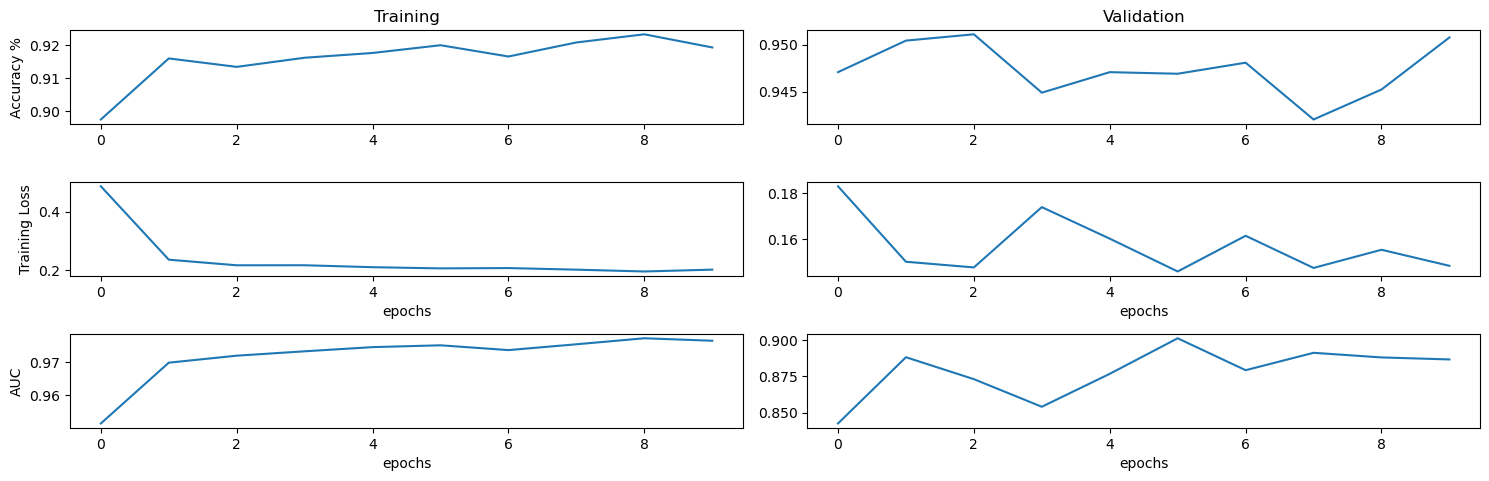

In [74]:
history = model_3.fit(
    preprocessed_train, epochs=10, validation_data=preprocessed_test, verbose=2
)

plot_hist()


 - [2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two models (this "two" includes the wide and deep model trained from the previous step). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to answer: What model with what number of layers performs superiorly? Use proper statistical methods to compare the performance of different models.
 


 - [1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.  


## Exceptional Work (1 points total)
5000 students: You have free reign to provide additional analyses.
One idea (required for 7000 level students): Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

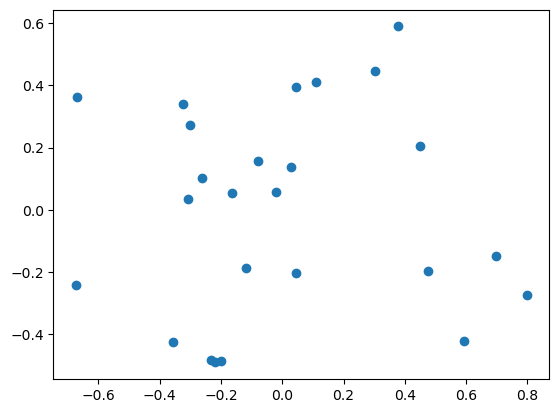

In [75]:
embedding_layer = inference_model.get_layer(name='deep3')
embeddings = embedding_layer.get_weights()[0]

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
plt.show()